The goal of this notebook is to evaluate the performance of several state-of-the-art classifiers on the ACES RFS (Recurrence-Free Survival) data, using sample-specific coexpression networks.

We will use the same two cros-validation settings as the FERAL paper [Allahyar and de Ridder, 2015]:
* a 10-fold, subtype-stratified CV (in which the proportions of breast cancer subtypes are kept constant in each fold)
* a 12-fold, leave-one-study-out CV (in which all the samples from one study are forming a test set in turns, and half of the other studies form the corresponding training set).

We will test the following algorithms:
* L1-regularized logistic regression
* L1/L2-regularized logistic regression.

In [ ]:
# Splits for 10 repeats of 10-fold subtype-stratified CV
for repeat in {0..9}
do 
  py setUpSubTypeStratifiedCV.py ${repeat};
done

Computation on the cluster:
SamSpecCoEN/sh/qsub_run_setupSubtypeStratifiedCV_writeIndices.sh

followed by:
SamSpecCoEN/sh/qsub_run_setupSubtypeStratifiedCV_computeNetworks.sh

In [1]:
import h5py
import gzip
import sys
sys.path.append("code/")
import InnerCrossVal
import numpy as np
from sklearn import linear_model as sklm 
from sklearn import  metrics as skm
from sklearn import cross_validation as skcv 

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
orange_color = '#d66000'
blue_color = '#005599'

### Load data

In [67]:
fold_nr = 5
data_dir = 'outputs/U133A_combat_RFS/subtype_stratified/repeat0/fold%d' % fold_nr
reload(InnerCrossVal)
icv = InnerCrossVal.InnerCrossVal('ACES', 
                                  data_dir, 
                                  'regline',  
                                   5, max_nr_feats=1000)

Using edge weights as features



# Using edge weights as features

In [68]:
#regParams = [10.**k for k in range(-3, 3)]
#regParams = [10.**k for k in range(-5, 1)]
regParams = [2.**k for k in range(-8, -2)]
#regParams = [np.exp(k) for k in range(-6, 0)]
print regParams
cvClassif = sklm.LogisticRegressionCV(Cs=regParams, penalty='l1', solver='liblinear', 
                                      scoring='roc_auc',
                                      class_weight='balanced')

[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125]


### Without normalization

In [ ]:
cvClassif.fit(icv.x_tr, icv.y_tr)

In [ ]:
print cvClassif.C_

In [ ]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l1', solver='liblinear',
                              class_weight='balanced')
clf.fit(icv.x_tr, icv.y_tr)

In [ ]:
ytr_pred = clf.predict_proba(icv.x_tr)

In [ ]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
#print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
a = plt.legend(bbox_to_anchor=(1, 0, 1, 1))

In [ ]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features."

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [ ]:
yte_pred = clf.predict_proba(icv.x_te)

In [ ]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)
plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

### With normalization

In [ ]:
# Normalization
Xmean = np.mean(icv.x_tr, axis = 0)
Xstdv = np.std(icv.x_tr, axis = 0, ddof = 1)

Xtr_norm = (icv.x_tr - Xmean)/Xstdv
Xte_norm = (icv.x_te - Xmean)/Xstdv

In [ ]:
print icv.x_tr.shape
edge_idx=np.random.choice(np.arange(Xtr_norm.shape[1]))
a = plt.hist(icv.x_tr[:, edge_idx], normed=True, bins=150, edgecolor='none', 
            color=blue_color, alpha=0.75, label="Xtr")
a = plt.hist(Xtr_norm[:, edge_idx], normed=True, bins=150, edgecolor='none', 
            color=orange_color, alpha=0.75, label="Xtr normed")
plt.title("Values for feature (edge) %d" % edge_idx)
leg = plt.legend() 

In [ ]:
cvClassif.fit(Xtr_norm, icv.y_tr)

In [ ]:
print cvClassif.C_

In [ ]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l1', solver='liblinear',
                              class_weight='balanced')
clf.fit(Xtr_norm, icv.y_tr)

In [ ]:
ytr_pred = clf.predict_proba(Xtr_norm)

In [ ]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

In [ ]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features"

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [ ]:
yte_pred = clf.predict_proba(Xte_norm)

In [ ]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

## Elastic Net 

In [ ]:
print [2.**k for k in range(-8, -2)]
print [2.**k for k in range(-6, -3)]

In [ ]:
# Grid search Elastic Net (for classification)
#alpha_values = [2.**k for k in range(-8, -2)]
l1_ratio_values = [.1, .5, .7, .9, .95, .99]
#l1_ratio_values = [float(k+1)/7 for k in range(6)]

#lbd_values = [2.**k for k in range(-6, -3)] #[2.**k for k in range(-8, -2)]
lbd_values = [10.**k for k in range(-7, -2)]

auc_dict = {} # auc:params

cross_validator = skcv.StratifiedKFold(icv.Ytr, 5)

# for alpha in alpha_values:
for lbd in lbd_values:
     for l1_ratio in l1_ratio_values:
        alpha = lbd / l1_ratio

        clf = sklm.SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha, l1_ratio=l1_ratio)
        y_true = []
        y_pred = []
        for tr, te in cross_validator:
            clf.fit(icv.Xtr[tr, :], icv.Ytr[tr])
            ytr_te_pred = clf.predict_proba(icv.Xtr[te, :])
            ix = clf.classes_.tolist().index(1)
            y_pred.extend(ytr_te_pred[:, ix])
            y_true.extend(icv.Ytr[te])            
            
        auc = skm.roc_auc_score(y_true, y_pred)
        print "alpha", alpha, "\tl1_ratio", l1_ratio, "\tauc", auc
        if not auc_dict.has_key(auc):
            auc_dict[auc] = []
        auc_dict[auc].append([alpha, l1_ratio])

auc_values = auc_dict.keys()
auc_values.sort()
best_auc = auc_values[-1]
print "Best AUC: ", best_auc

print auc_dict[best_auc]               

In [ ]:
# Run Elastic Net
alpha = auc_dict[best_auc][0][0]
l1_ratio = auc_dict[best_auc][0][1]

clf = sklm.SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha, l1_ratio=l1_ratio)

clf.fit(icv.Xtr, icv.Ytr)
ytr_pred = clf.predict_proba(icv.Xtr)

ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.Ytr > 0)[0]
tr_neg_indices = np.where(icv.Ytr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.Ytr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.Ytr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

In [ ]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features"
plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='+', ls='')

In [ ]:
yte_pred = clf.predict_proba(icv.Xte)
te_pos_indices = np.where(icv.Yte > 0)[0]
te_neg_indices = np.where(icv.Yte == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.Yte[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.Yte[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "AUC:", skm.roc_auc_score(icv.Yte, yte_pred[:, ix])

# Using node weights (gene expression data) as feature

In [ ]:
sys.path.append('ACES')
from datatypes.ExpressionDataset import HDF5GroupToExpressionDataset

f = h5py.File("ACES/experiments/data/U133A_combat.h5")
acesData = HDF5GroupToExpressionDataset(f['U133A_combat_RFS'], checkNormalise=False)
f.close()

Z = acesData.expressionData

In [ ]:
trIndices = np.loadtxt('%s/train.indices' % data_dir, dtype='int')
teIndices = np.loadtxt('%s/test.indices' % data_dir, dtype='int')

Ztr = Z[trIndices, :]
Zte = Z[teIndices, :]

In [ ]:
# Normalization
Zmean = np.mean(Ztr, axis = 0)
Zstdv = np.std(Ztr, axis = 0, ddof = 1)

Ztr_norm = (Ztr - Zmean)/Zstdv
Zte_norm = (Zte - Zmean)/Zstdv

In [ ]:
node_idx = np.random.choice(np.arange(Ztr_norm.shape[1]))
a = plt.hist(Ztr[:, node_idx], normed=True, bins=150, edgecolor='none', 
             color=blue_color, alpha=0.75, label="Ztr")
a = plt.hist(Ztr_norm[:, node_idx], normed=True, bins=150, edgecolor='none', 
             color=orange_color, alpha=0.75, label="Ztr normed")
plt.title("Values for feature (gene) %d" % node_idx)
leg = plt.legend() 

## L1-regularized logistic regression

In [ ]:
regParams = [2.**k for k in range(-8, -2)]
cvClassif = sklm.LogisticRegressionCV(Cs=regParams, penalty='l1', solver='liblinear',
                                     class_weight='balanced', scoring='roc_auc')

In [ ]:
cvClassif.fit(Ztr_norm, icv.y_tr)

In [ ]:
print cvClassif.C_

In [ ]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l1', solver='liblinear',
                              class_weight='balanced')
clf.fit(Ztr_norm, icv.y_tr)

In [ ]:
ytr_pred = clf.predict_proba(Ztr_norm)

In [ ]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

In [ ]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features."

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [ ]:
yte_pred = clf.predict_proba(Zte_norm)

In [ ]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

## Sfan

In [ ]:
print Ztr.shape

In [ ]:
# Scores: Use correlation between X and phenotype (only on train data)
num_genes = Ztr_norm.shape[1]
import scipy.stats as st

scores = [st.pearsonr(Ztr_norm[:, gene_idx], icv.y_tr)[0]**2 \
          for gene_idx in range(num_genes)]

node_weights_f = "%s/scores.txt" % data_dir
np.savetxt(node_weights_f, scores, fmt='%.3e')

In [ ]:
num_edges = icv.x_tr.shape[1]
edges_f = '%s/edges.gz' % data_dir
ntwk_dimacs_f = "%s/network.dimacs" % data_dir


In [ ]:
# Correlation network is edges.gz (no weights)
# (for weights, go back to CoExpressionNetwork.createGlobalNetwork)
# format: <index of gene 1> <index of gene 2>
# transform into .dimacs file
sym_edges_dict = {} #j:[i]
last_idx = 0


# temporary dimacs file
import os
import tempfile

tmp_fname = 'tmp.dimacs'
fd, tmp_fname = tempfile.mkstemp()

# keep track of nodes that have at least one neighbor
connected_nodes = set([]) 

with open(tmp_fname, 'w') as g:
    g.write("p max %d %d\n" % (num_genes, num_edges*2))
    with gzip.open(edges_f, 'r') as f:     
        for line in f:
            idx_1, idx_2 = [int(x) for x in line.split()]
            # track nodes as connected
            connected_nodes.add(idx_1)
            connected_nodes.add(idx_2)
            # write edges saved in sym_edges_dict:
            for idx_3 in range(last_idx, idx_1+1):
                if sym_edges_dict.has_key(idx_3):
                    for idx_0 in sym_edges_dict[idx_3]:
                        g.write("a %d %d 1\n" % (idx_3, idx_0))
                    # delete these entries
                    del sym_edges_dict[idx_3]                   
            # update last_idx
            last_idx = idx_1            
            # write this edge
            g.write("a %d %d 1\n" % (idx_1, idx_2))
            # add to dictionary
            if not sym_edges_dict.has_key(idx_2):
                sym_edges_dict[idx_2] = []
            sym_edges_dict[idx_2].append(idx_1)
        f.close()        
        # write the end of the dictionary
        if len(sym_edges_dict):
            sym_edges_dict_keys = sym_edges_dict.keys()
            sym_edges_dict_keys.sort()
            for idx_1 in sym_edges_dict_keys:
                for idx_0 in sym_edges_dict[idx_1]:
                    g.write("a %d %d 1\n" % (idx_1, idx_0))
    g.close()           
    
# Restrict data to nodes that belong to the network:
connected_nodes = list(connected_nodes)
connected_nodes.sort()
Ztr_norm_sfan = Ztr_norm[:, connected_nodes]
Zte_norm_sfan = Zte_norm[:, connected_nodes]

num_genes_in_ntwk = len(connected_nodes)
print "%d nodes in the network." % num_genes_in_ntwk

# Map node IDs in temporary dimacs to the final ones
map_idx = {}        
for (old_idx, new_idx) in zip(connected_nodes, range(num_genes_in_ntwk)):
    map_idx[old_idx] = new_idx + 1 # indices start at 1 in dimacs file                                      

# Update node IDs in ntwk_dimacs
with open(ntwk_dimacs_f, 'w') as g:
    g.write("p max %d %d\n" % (num_genes_in_ntwk, num_edges*2))
    with open(tmp_fname, 'r') as f:
        f.readline() # header
        for line in f:
            ls = line.split()
            g.write("a %d %d %s\n" % (map_idx[int(ls[1])], map_idx[int(ls[2])], ls[3]))
        f.close()
    g.close()
    
# Delete temporary file
os.remove(tmp_fname)        

In [ ]:
# Run sfan 
import subprocess
lbd = '0.10'
eta = '0.01'

msfanpy = "/home/cazencott/Research/Projects/sfan/code/multitask_sfan.py"
argum = ['python', msfanpy, '--num_tasks', '1',
         '--networks', ntwk_dimacs_f, 
         '--node_weights', node_weights_f,
         '-l', lbd, '-e', eta, '-m', '0']
print "Running: ", " ".join(argum)
p = subprocess.Popen(argum, stdout=subprocess.PIPE)
#print p.communicate()
p_out = p.communicate()[0].split("\n")[2]
#print p_out
sel_list = [(int(x)-1) for x in p_out.split()]

# Look at selected features
print len(sel_list), "selected features."

In [ ]:
# Train a ridge-logistic-regression on the selected features
Ztr_sel = Ztr_norm_sfan[:, sel_list]
Zte_sel = Zte_norm_sfan[:, sel_list]

regParams = [2.**k for k in range(-8, -2)]
cvClassif = sklm.LogisticRegressionCV(Cs=regParams, penalty='l2', solver='liblinear',
                                     class_weight='balanced', scoring='roc_auc')

In [ ]:
cvClassif.fit(Ztr_sel, icv.y_tr)

In [ ]:
print cvClassif.C_

In [ ]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l2', solver='liblinear',
                              class_weight='balanced')
clf.fit(Ztr_sel, icv.y_tr)

In [ ]:
ytr_pred = clf.predict_proba(Ztr_sel)

In [ ]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

In [ ]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features."

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [ ]:
yte_pred = clf.predict_proba(Zte_sel)

In [ ]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

# Plotting data

## AUCs

In [5]:
results_dir = 'outputs/U133A_combat_RFS/subtype_stratified/'
figure_path = '%s/subtype_stratified_auc.pdf' % results_dir
num_repeats = 10

aucs_dict = {'nodes_l1logreg': [],
                 'lioness_l1logreg': [],
                 'regline_l1logreg': []}#, 'sfan_l2logreg': []

# read AUCs
for repeat_idx in range(num_repeats):
    repeat_dir = '%s/repeat%d/results' % (results_dir, repeat_idx)

    # L1-logreg on node weights
    with open('%s/results.txt' % repeat_dir, 'r') as f:
        for line in f:
            ls = line.split()
            if ls[0] == "AUC:":
                auc = float(ls[1])
                break
        f.close()
    aucs_dict['nodes_l1logreg'].append(auc)

    # L1-logreg on edge weights
    for ntwk in ['lioness', 'regline']:
        with open('%s/%s/results.txt' % (repeat_dir, ntwk), 'r') as f:
            for line in f:
                ls = line.split()
                if ls[0] == "AUC:":
                    auc = float(ls[1])
                    break
            f.close()
        aucs_dict['%s_l1logreg' % ntwk].append(auc)

(0.63, 0.78)

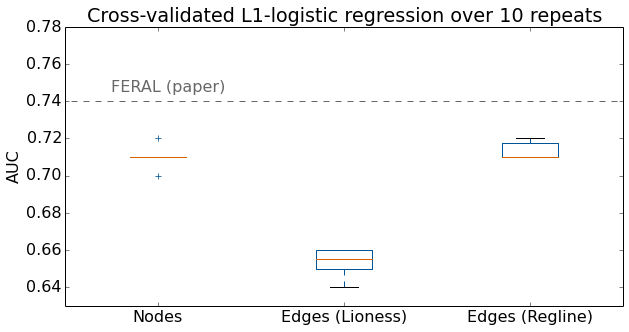

In [25]:
plt.rcParams.update({'font.size': 16})

auc_data = np.array([aucs_dict['nodes_l1logreg'],
                     aucs_dict['lioness_l1logreg'],
                     aucs_dict['regline_l1logreg']])
auc_data = np.transpose(auc_data)

plt.figure(figsize=(10, 5))

bp = plt.boxplot(auc_data)
plt.setp(bp['boxes'], color=blue_color)
plt.setp(bp['whiskers'], color=blue_color)
plt.setp(bp['fliers'], color=blue_color)
plt.setp(bp['medians'], color=orange_color)

plt.plot(range(5), [0.74 for x in range(5)], 
         ls='--', color='#666666')
plt.text(0.75, 0.745, 'FERAL (paper)', color='#666666')

plt.title('Cross-validated L1-logistic regression over %d repeats' % num_repeats)
plt.ylabel('AUC')
labels = ('Nodes', 'Edges (Lioness)', 'Edges (Regline)')
plt.xticks(range(1, 4), labels)#, rotation=35)
plt.ylim(0.63, 0.78)


## Number of features

In [61]:
numf_dict = {'nodes_l1logreg': [],
             'lioness_l1logreg': [],
              'regline_l1logreg': []}#, 'sfan_l2logreg': []

# read number of selected features
for repeat_idx in range(num_repeats):
    repeat_dir = '%s/repeat%d/results' % (results_dir, repeat_idx)

    # L1-logreg on node weights
    with open('%s/results.txt' % repeat_dir, 'r') as f:
        for line in f:
            ls = line.split('\t')
            if ls[0] == "Number of features selected per fold:":
                #print ls[1].split()
                numf_list = [int(x) for x in ls[1].split()]
                break
        f.close()
    numf_dict['nodes_l1logreg'].extend(numf_list)

    # L1-logreg on edge weights
    for ntwk in ['lioness', 'regline']:
        with open('%s/%s/results.txt' % (repeat_dir, ntwk), 'r') as f:
            for line in f:
                ls = line.split('\t')
                if ls[0] == "Number of features selected per fold:":
                    numf_list = [int(x) for x in ls[1].split()]
                    break
            f.close()
        numf_dict['%s_l1logreg' % ntwk].extend(numf_list)
#print numf_dict

([<matplotlib.axis.XTick at 0x7fed7d1511d0>,
 <a list of 3 Text xticklabel objects>)

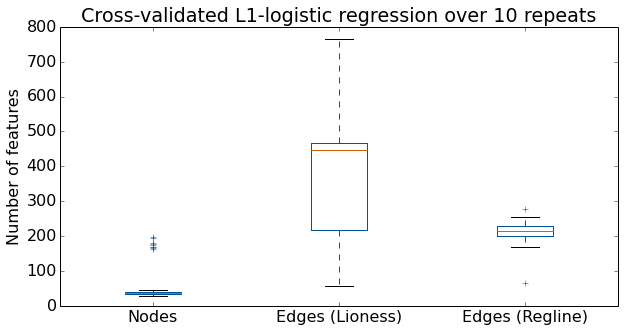

In [62]:
numf_data = np.array([numf_dict['nodes_l1logreg'],
                      numf_dict['lioness_l1logreg'],
                      numf_dict['regline_l1logreg']])
numf_data = np.transpose(numf_data)

plt.figure(figsize=(10, 5))

bp = plt.boxplot(numf_data)
plt.setp(bp['boxes'], color=blue_color)
plt.setp(bp['whiskers'], color=blue_color)
plt.setp(bp['fliers'], color=blue_color)
plt.setp(bp['medians'], color=orange_color)

plt.title('Cross-validated L1-logistic regression over %d repeats' % num_repeats)
plt.ylabel('Number of features')
labels = ('Nodes', 'Edges (Lioness)', 'Edges (Regline)')
plt.xticks(range(1, 4), labels)#, rotation=35)
#plt.ylim(0., 1.)

## Consistency index

In [56]:
import string

cix_dict = {'nodes_l1logreg': [],
            'lioness_l1logreg': [],
            'regline_l1logreg': []}#, 'sfan_l2logreg': []

# read consistency indices
for repeat_idx in range(num_repeats):
    repeat_dir = '%s/repeat%d/results' % (results_dir, repeat_idx)

    # L1-logreg on node weights
    with open('%s/results.txt' % repeat_dir, 'r') as f:
        for line in f:
            ls = line.split('\t')
            if ls[0] == "Stability (Consistency Index):":
                #print ls[0]
                #print [string.lstrip(string.rstrip(x, ",']\n"), ",' [") for x in ls[-1].split(",")]
                cix_list = [float(string.lstrip(string.rstrip(x, ",']\n"), ",' [")) \
                            for x in ls[-1].split(",")]
                #print cix_list
                break
        f.close()
    cix_dict['nodes_l1logreg'].extend(cix_list)

    # L1-logreg on edge weights
    for ntwk in ['lioness', 'regline']:
        with open('%s/%s/results.txt' % (repeat_dir, ntwk), 'r') as f:
            for line in f:
                ls = line.split('\t')
                if ls[0] == "Stability (Consistency Index):":
                    cix_list = [float(string.lstrip(string.rstrip(x, ",']\n"), ",' [")) \
                                for x in ls[-1].split(",")]
                    #print cix_list
                    break
            f.close()
        cix_dict['%s_l1logreg' % ntwk].extend(cix_list)

(0.0, 1.0)

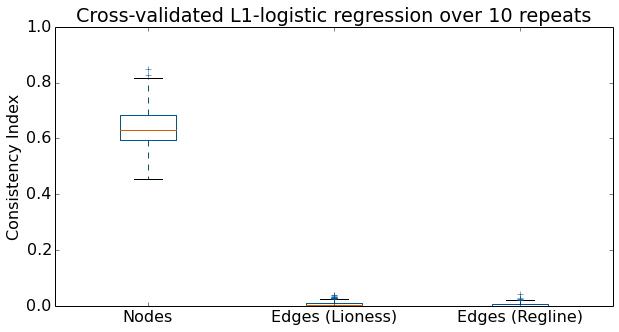

In [58]:
plt.rcParams.update({'font.size': 16})

cix_data = np.array([cix_dict['nodes_l1logreg'],
                     cix_dict['lioness_l1logreg'],
                     cix_dict['regline_l1logreg']])
cix_data = np.transpose(cix_data)

plt.figure(figsize=(10, 5))

bp = plt.boxplot(cix_data)
plt.setp(bp['boxes'], color=blue_color)
plt.setp(bp['whiskers'], color=blue_color)
plt.setp(bp['fliers'], color=blue_color)
plt.setp(bp['medians'], color=orange_color)

plt.title('Cross-validated L1-logistic regression over %d repeats' % num_repeats)
plt.ylabel('Consistency Index')
labels = ('Nodes', 'Edges (Lioness)', 'Edges (Regline)')
plt.xticks(range(1, 4), labels)#, rotation=35)
plt.ylim(0., 1.)

## Fisher overlap

In [64]:
import string

fov_dict = {'nodes_l1logreg': [],
            'lioness_l1logreg': [],
            'regline_l1logreg': []}#, 'sfan_l2logreg': []

# read consistency indices
for repeat_idx in range(num_repeats):
    repeat_dir = '%s/repeat%d/results' % (results_dir, repeat_idx)

    # L1-logreg on node weights
    with open('%s/results.txt' % repeat_dir, 'r') as f:
        for line in f:
            ls = line.split('\t')
            if ls[0] == "Stability (Fisher overlap):":
                #print ls[0]
                #print [string.lstrip(string.rstrip(x, ",']\n"), ",' [") for x in ls[-1].split(",")]
                fov_list = [float(string.lstrip(string.rstrip(x, ",']\n"), ",' [")) \
                            for x in ls[-1].split(",")]
                #print fov_list
                break
        f.close()
    fov_dict['nodes_l1logreg'].extend(fov_list)

    # L1-logreg on edge weights
    for ntwk in ['lioness', 'regline']:
        with open('%s/%s/results.txt' % (repeat_dir, ntwk), 'r') as f:
            for line in f:
                ls = line.split('\t')
                if ls[0] == "Stability (Fisher overlap):":
                    fov_list = [float(string.lstrip(string.rstrip(x, ",']\n"), ",' [")) \
                                for x in ls[-1].split(",")]
                    #print fov_list
                    break
            f.close()
        fov_dict['%s_l1logreg' % ntwk].extend(fov_list)

([<matplotlib.axis.XTick at 0x7fed7d0d4590>,
 <a list of 3 Text xticklabel objects>)

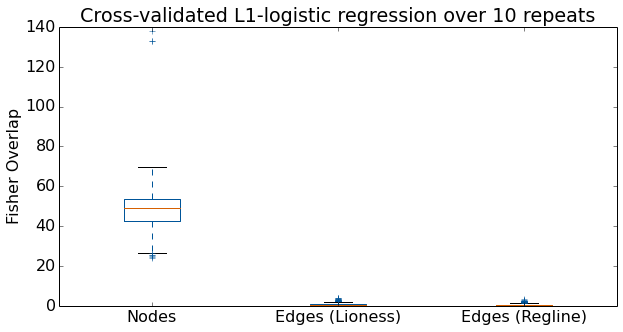

In [66]:
plt.rcParams.update({'font.size': 16})

fov_data = np.array([fov_dict['nodes_l1logreg'],
                     fov_dict['lioness_l1logreg'],
                     fov_dict['regline_l1logreg']])
fov_data = np.transpose(fov_data)

plt.figure(figsize=(10, 5))

bp = plt.boxplot(fov_data)
plt.setp(bp['boxes'], color=blue_color)
plt.setp(bp['whiskers'], color=blue_color)
plt.setp(bp['fliers'], color=blue_color)
plt.setp(bp['medians'], color=orange_color)

plt.title('Cross-validated L1-logistic regression over %d repeats' % num_repeats)
plt.ylabel('Fisher Overlap')
labels = ('Nodes', 'Edges (Lioness)', 'Edges (Regline)')
plt.xticks(range(1, 4), labels)#, rotation=35)
#plt.ylim(0., 1.)